<span style="font-size:25px">
The following methods are existing baseline methods in explainable AI applied to my full_mnist FFN.
</span>

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random as ra

from scipy.ndimage import gaussian_filter
from captum.attr import LRP
import plotly.graph_objects as go
import plotly.express as px
import umap.umap_ as umap


In [91]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16
out_size = 10
epochs = 10
batch_size = 64
learning_rate = 0.001

In [92]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [93]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.hidden_acts = []
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain = nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain = nn.init.calculate_gain('tanh'))

    def forward(self, x):
        a0 = self.tanh(self.fc0(x))
        a1 = self.tanh(self.fc1(a0))
        out = self.fc2(a1)
        self.hidden_acts = [a0, a1]
        return out

In [94]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [95]:
net.load_state_dict(torch.load("02_ffn_mnist_full.pth"))

<All keys matched successfully>

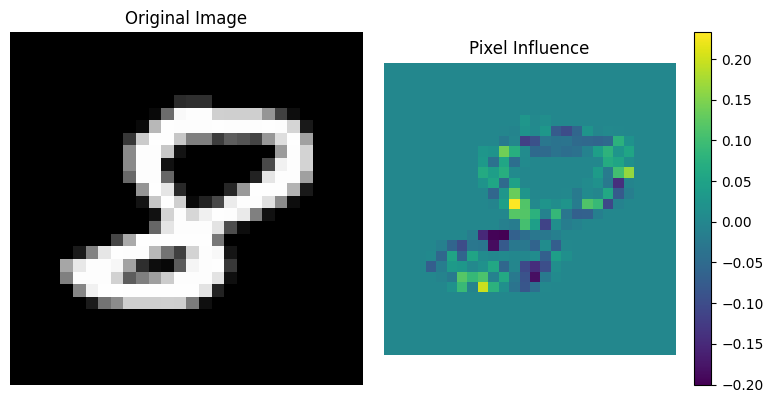

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs, labels = next(iter(test_loader))

while True: #search target class:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == 8:
        img = inputs[ind].squeeze()
        break

x = img.clone().detach().view(1, -1).to(device).requires_grad_(True)
output = net(x)
target_class = output.argmax(dim=1).item()
net.zero_grad()
output[0, target_class].backward()
attribution = (x.grad * x).view(28, 28)
saliency = attribution.cpu().detach().numpy()

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency)
plt.title("Pixel Influence")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


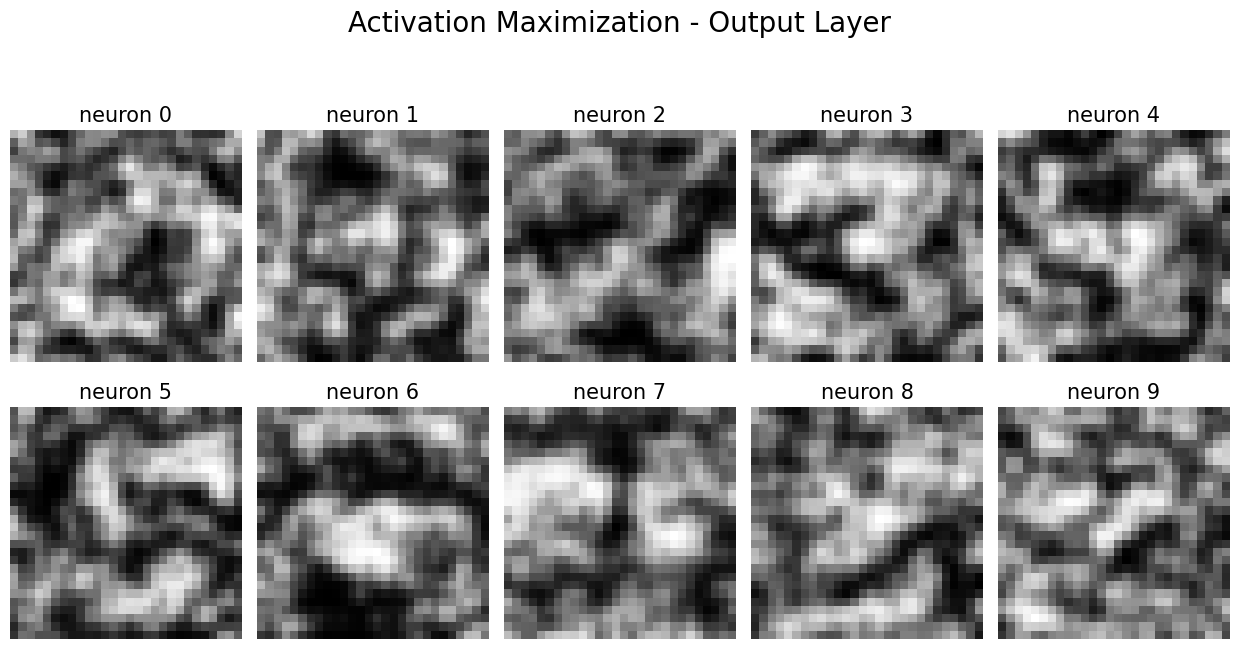

In [97]:
layer_idx = 2 #2 = out layer
layer_sizes = [32, 16, 10]
neuron_indices = list(range(layer_sizes[layer_idx]))
steps = 200
lr = 0.1
smoothing_sigma = 0.8

net.eval()
device = 'cuda' if CUDA else 'cpu'
images = []

for idx in neuron_indices:
    input_image = torch.randn(1, 784, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        logits = net(input_image)
        hidden_layers = net.hidden_acts
        activation = logits[0, idx] if layer_idx == 2 else hidden_layers[0][0, idx]
        loss = -activation
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            input_image.clamp_(0, 1)

    img_np = input_image.detach().cpu().view(28, 28).numpy()
    if smoothing_sigma > 0:
        img_np = gaussian_filter(img_np, sigma=smoothing_sigma)
    images.append(img_np)

#plotting
rows = -(-len(images) // 5)
plt.figure(figsize=(5 * 2.5, rows * 3.5))
for i, img in enumerate(images):
    plt.subplot(rows, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'neuron {neuron_indices[i]}', fontsize=15)
    plt.axis('off')

plt.suptitle(f'Activation Maximization - Output Layer', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#activation maximization gives all areas (white) that if overlapping with input >> 0 activate highly.
#However, most neurons have very scattered white areas -> they also partly activate on other inputs.

In [98]:
#adding 3d visualisation x, y, z with z = activation threshold for better interpretability

block_size = 4
new_size = 28 // block_size
class_idx = 0
activation_map = images[class_idx]

averaged_columns = activation_map.reshape(new_size, block_size, new_size, block_size).mean(axis=(1, 3))
norm = averaged_columns / averaged_columns.max()
colors = np.floor(norm * 255).astype(int)

fig = go.Figure()
dx = dy = 0.9

def add_cube(fig, x0, y0, h, gray):
    verts = np.array([
        [x0,     y0,     0], #square bottom of column
        [x0+dx,  y0,     0],
        [x0+dx,  y0+dy,  0],
        [x0,     y0+dy,  0],
        [x0,     y0,     h], #square top of column
        [x0+dx,  y0,     h],
        [x0+dx,  y0+dy,  h],
        [x0,     y0+dy,  h],
    ])

    i = [0, 0, 4, 5, 1, 1, 2, 2, 3, 3, 4, 7]
    j = [1, 3, 5, 6, 2, 5, 3, 6, 0, 7, 0, 4]
    k = [3, 2, 6, 7, 5, 4, 7, 4, 4, 6, 1, 5]
    color = f'rgb({gray},{gray},{gray})'

    fig.add_trace(go.Mesh3d(
        x = verts[:,0], y = verts[:,1], z = verts[:,2], #mesh vertices
        i = i, j = j, k = k,
        color = color, opacity = 1 #mesh color
    ))

for xi in range(new_size):
    for yi in range(new_size):
        h = averaged_columns[yi, new_size-1-xi]
        gray = colors[yi, new_size-1-xi]
        add_cube(fig, xi, yi, h, gray) #coordinates, height, color

fig.update_layout(
    scene = dict(
        xaxis = dict(title='x', showticklabels=False),
        yaxis = dict(title='y', showticklabels=False),
        zaxis = dict(title='Activation'),
        aspectmode = 'cube'
    ),
    title = f'x, y, z maximised activation bars, reduced input for class {class_idx}',
    width = 700, height=700
)

fig.show()


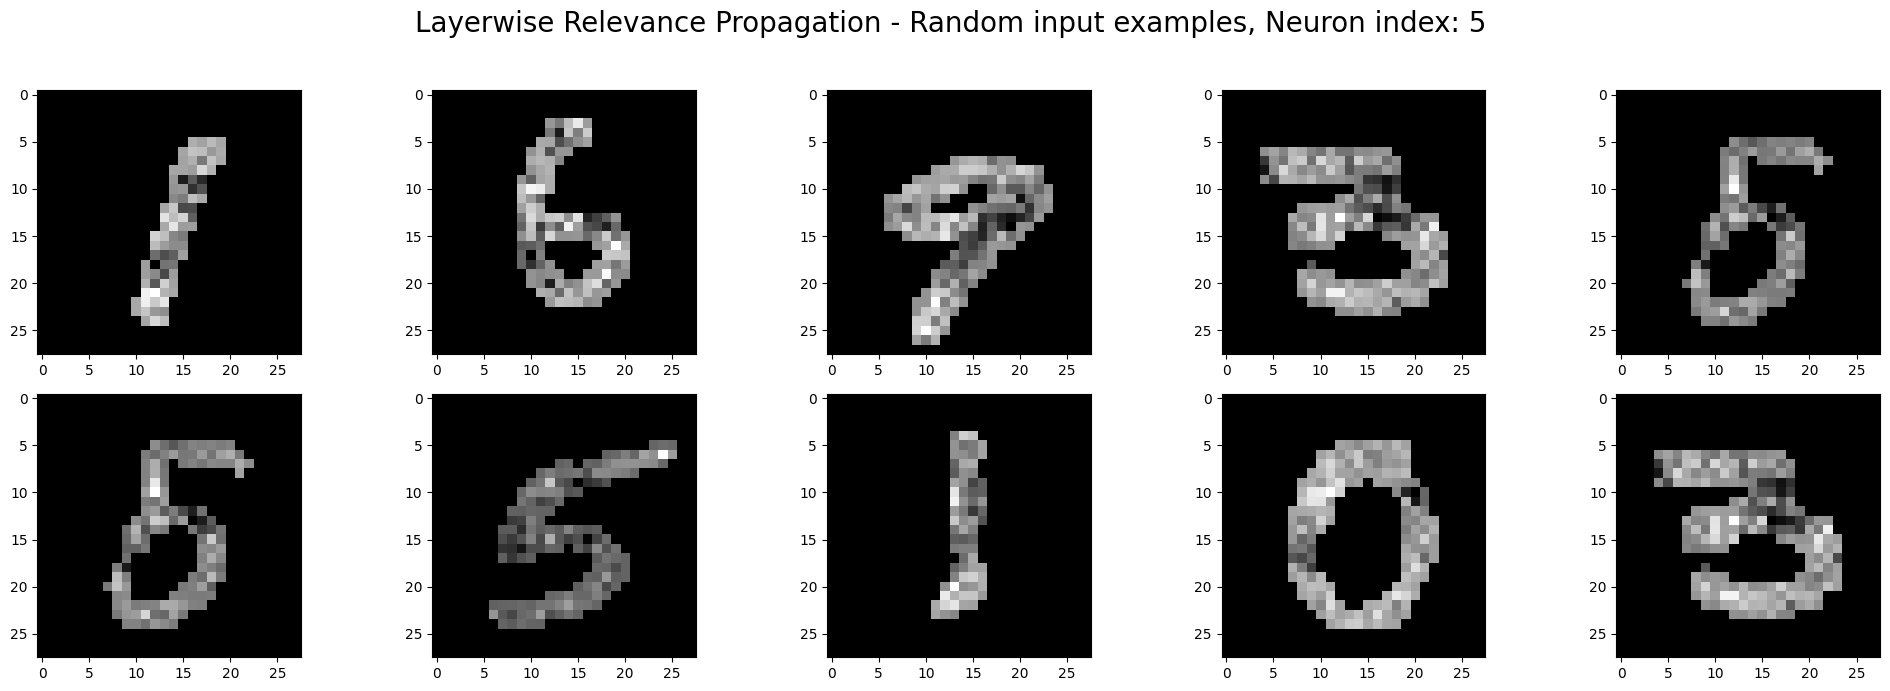

In [ ]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))
example_count = 10
target_class = torch.tensor(5).cuda()

plt.figure(figsize=(20, -(-example_count // 5) * 3.5))

for ind in range(example_count):
    ind_rand = ind + ra.randint(0, len(inputs) - 1 - example_count)
    input = inputs[ind_rand].unsqueeze(0)
    input.requires_grad_()
    input = input.cuda()

    lrp = LRP(net)
    attributions = lrp.attribute(input.view(1, 784), target=target_class)
    rel_map = attributions[0].cpu().detach().numpy().reshape(28, 28)

    input = input.cpu().detach().numpy().reshape(28, 28)
    back_ground = (input == 0)
    rel_map[back_ground] = rel_map.min()
    rel_map /= rel_map.max()

    plt.subplot(-(-example_count // 5), 5, ind + 1)
    plt.imshow(rel_map, cmap="gray")
    #plt.axis('off')

plt.suptitle(f'Layerwise Relevance Propagation - Random input examples, Neuron index: {target_class}', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<span style="font-size:25px">
Further baseline (existing) methods such as SHAP, LIME, counterfactuals, or surrogate models will not be executed here, but their theoretic limitations discussed later.
The above methods serve as examples for interpretable but limited methods.
Further experiments of my own will be aimed at further highlighting the limitations in explaining modern AI.
</span>

In [5]:
#MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
X = train_dataset.data.float() / 255.0 #[60000, 28, 28]
X = X.view(-1, 784)  #[60000, 784]
y = train_dataset.targets

n_samples = 10000
indices = torch.randperm(X.shape[0])[:n_samples]
X_sub = X[indices].numpy()
y_sub = y[indices].numpy()

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
projections = umap_model.fit_transform(X_sub)

fig = px.scatter(
    x=projections[:, 0],
    y=projections[:, 1],
    color=y_sub.astype(str),
    title='UMAP of MNIST Digits',
    labels={'x': 'UMAP Component 1', 'y': 'UMAP Component 2'},
    render_mode='webgl'
)
fig.update_traces(marker=dict(size=4, opacity=0.6))
fig.update_layout(
    width=900,
    height=700,
    title={'x': 0.5, 'xanchor': 'center'},
    legend=dict(title='Digit', orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
)
fig.show(renderer="browser")

/home/kns357/Desktop/ann_ma_kaito/venv0/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
